In [1]:
import pandas as pd
import seaborn as sns
import jsonlines

In [2]:
import os

def find_files_with_extension(_dir, ext):
    for root, dirs, files in os.walk(_dir):
        for file in files:
            if file.endswith(ext):
                yield os.path.join(root, file)

def load_jsonlines(filename):
    with jsonlines.open(filename) as r:
        for obj in r:
            yield obj

def jsonl_dir_as_df(_dir):
    files_g = find_files_with_extension(_dir, ".jsonl")
    df = pd.DataFrame.from_records(
        l for fn in files_g for l in load_jsonlines(fn)
    )
    return df

In [3]:
def add_rolling_mean(df, columns, window, groupby, sortby):
    rolling = df.sort_values(sortby)[columns].groupby(df['mode']).rolling(window=window).mean()
    rolling.index = rolling.index.droplevel(level=0)
    rolling_columns = [f'{c}_rolling' for c in columns]
    df[rolling_columns] = rolling
    return df

In [4]:
df = jsonl_dir_as_df('../runs/djx_test_heu')

In [5]:
df.columns

Index(['label.batch', 'label.n_agents', 'label.networktype', 'label.project',
       'label.self_weight', '_step', 'episode', 'mode', 'episode_step',
       'ai_eps', 'ci_eps', 'done', 'agent_type', 'createdAt', 'rewards',
       'avg_reward', 'episode_rewards', 'avg_episode_rewards', 'coordinations',
       'catches'],
      dtype='object')

In [6]:
dfs = df[df['label.batch'] == 'test_djx_heuristic']

In [7]:
dfd = dfs[dfs['done']]

In [8]:
pd.__version__


'1.0.5'

In [9]:
dfi = pd.DataFrame(
    dfs['episode_rewards'].tolist(), 
    index=pd.MultiIndex.from_frame(dfs[['episode', 'mode']])
)
dfi.columns.name = 'agent_idx'
dfi = dfi.stack()
dfi.name = 'individual_reward'
dfi = dfi.to_frame().reset_index()
dfi = add_rolling_mean(dfi, ['individual_reward'], 1000 , ['mode', 'agent_idx'], 'episode')

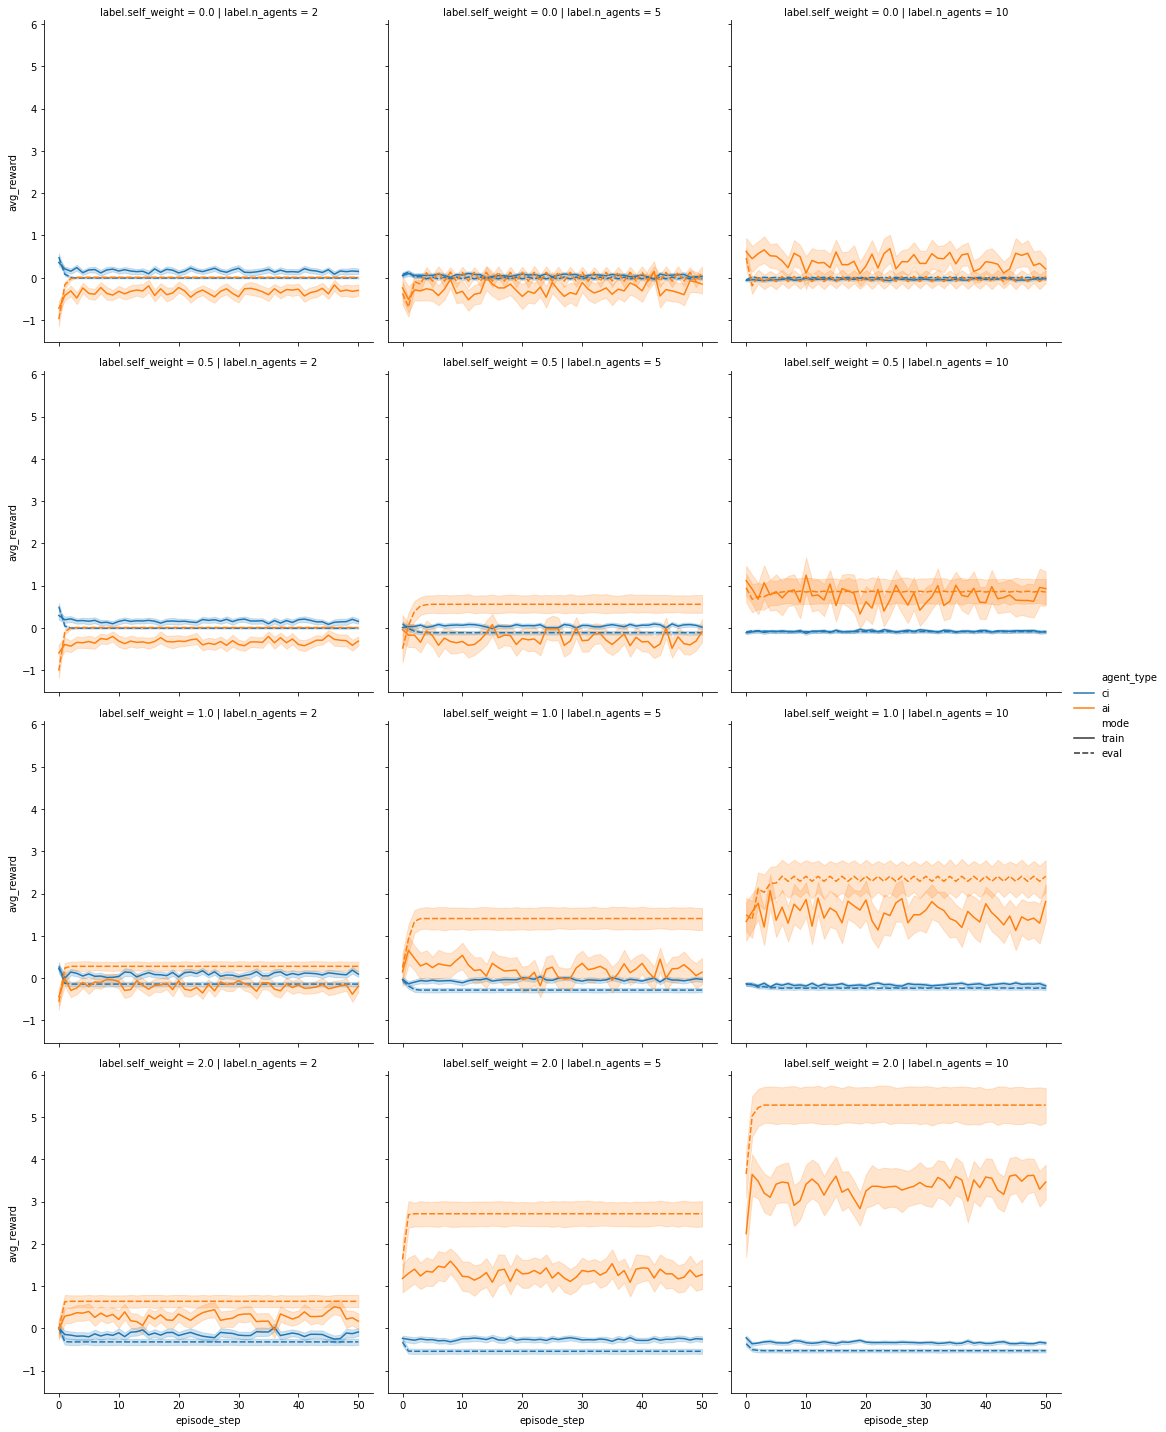

In [22]:
dfss = dfs[(dfs["label.networktype"] == 'dense')]

sns.relplot(data=dfss, x='episode_step', y='avg_reward', hue='agent_type', style='mode', col="label.n_agents",  row="label.self_weight", kind="line")

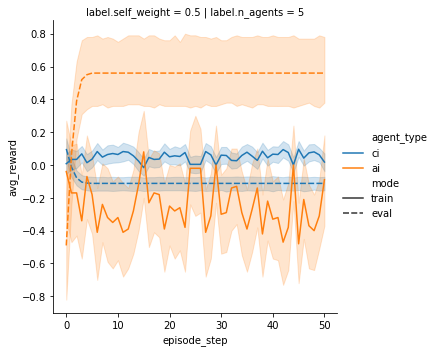

In [23]:
dfss = dfs[(dfs["label.networktype"] == 'dense') & (dfs["label.self_weight"] == 0.5) & (dfs["label.n_agents"] == 5)]
sns.relplot(data=dfss, x='episode_step', y='avg_reward', hue='agent_type', style='mode', col="label.n_agents",  row="label.self_weight", kind="line")

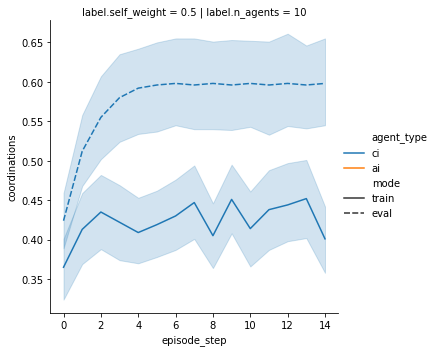

In [32]:
dfss = dfs[(dfs["label.networktype"] == 'dense') & (dfs["label.self_weight"] == 0.5) & (dfs["label.n_agents"] == 10) & (dfs["episode_step"] < 15)]
sns.relplot(data=dfss, x='episode_step', y='coordinations', hue='agent_type', style='mode', col="label.n_agents",  row="label.self_weight", kind="line")

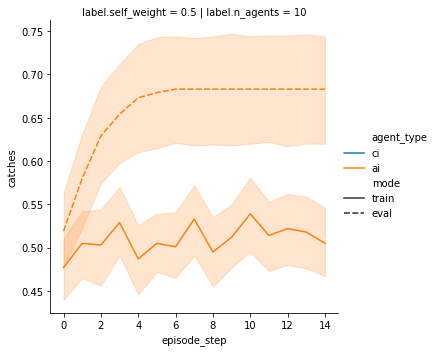

In [33]:
dfss = dfs[(dfs["label.networktype"] == 'dense') & (dfs["label.self_weight"] == 0.5) & (dfs["label.n_agents"] == 10) & (dfs["episode_step"] < 15)]
sns.relplot(data=dfss, x='episode_step', y='catches', hue='agent_type', style='mode', col="label.n_agents",  row="label.self_weight", kind="line")

In [20]:

dfss = dfs[(dfs["label.networktype"] == 'dense')]

g = sns.FacetGrid(dfs, col="label.n_agents",  row="label.self_weight", x='episode_step', y='avg_reward', hue='agent_type', style='mode')
g = g.map(sns.lineplot)

TypeError: __init__() got an unexpected keyword argument 'x'

In [ ]:



g = sns.FacetGrid(dfs, col="label.n_agents",  row="label.networktype")
g = g.map(plt.hist, "total_bill")

In [10]:
dfd = add_rolling_mean(dfd, ['avg_episode_rewards', 'episode_step'], 100 , 'mode', 'episode')

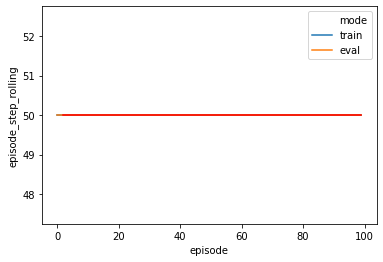

In [11]:
sns.lineplot(data=dfd, x='episode', y='episode_step', hue='mode')
sns.lineplot(data=dfd[dfd['mode'] == 'train'], x='episode', y='episode_step_rolling', color='red')

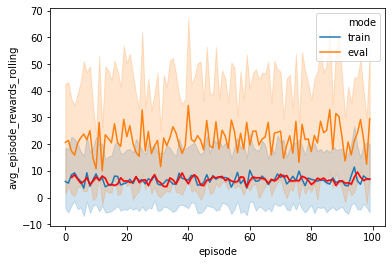

In [12]:
sns.lineplot(data=dfd, x='episode', y='avg_episode_rewards', hue='mode')
sns.lineplot(data=dfd[dfd['mode'] == 'train'], x='episode', y='avg_episode_rewards_rolling', color='red')

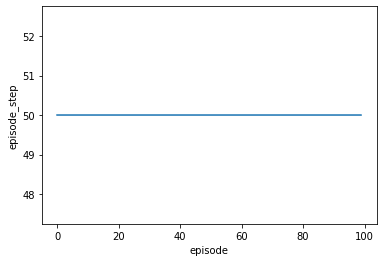

In [14]:
sns.lineplot(data=dfd[dfd['mode'] == 'eval'], x='episode', y='episode_step')

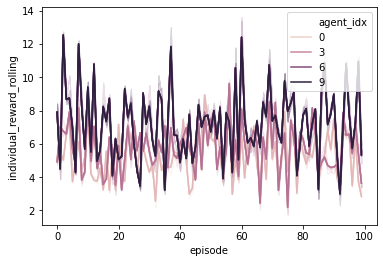

In [15]:
sns.lineplot(data=dfi[dfi['mode'] == 'train'], x='episode', y='individual_reward_rolling', hue='agent_idx', n_boot=1)